<i><b>Public AI</b></i>
<br>

# Factorization Machine 알고리즘 및 구현하기

현업 실무에서 우리는 상호작용 데이터뿐 아니라 User 또는 Item의 다양한 특성데이터를 함께 활용해야 할 수도 있습니다.
하지만 우리가 이전에 배운 CF의 경우에는 User-Item 의 Interation Matrix에는 특성데이터를 더하기란 쉽지 않은데요,
이번 시간에는 각 로그별로 모델을 학습시켜 각 특성별, 그리고 특성의 상호작용별 가중치를 찾아 고객의 선호를 예측하는
Factorization Machine에 대해 배워보겠습니다.

### _Objective_
1. 이전에 배웠던 MovieLens데이터에서 고객과 영화의 정보를 어떻게 활용할 수 있을지 알아봅니다.
2. Categorical Feature의 인코딩 방법에 대해 알아봅니다.
3. Factorization Machine의 필요성과 기본 원리를 이해합니다.

In [1]:
%matplotlib inline
import os
import random

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import get_file
from tensorflow.keras import backend as K
from tqdm import tqdm
np.set_printoptions(5,)

# \[ 1. 문제 정의 \]
---

## 추천 시스템에서 특성 데이터 활용하기

이전 시간에는 "협업 필터링(Collaborative Filtering)"이라는 추천알고리즘의 방법론 중 한 갈래를 배웠습니다. 협업 필터링은 유저의 아이템에 대한 행동인 "상호작용 데이터(Interaction Data)"를 활용하는 방법이었습니다. 유저-아이템 간 상호작용 데이터에 드러난 선호를 파악해 아직 상호작용이 발생하지 않은 유저와 아이템에 대한 선호를 유추하여 추천 아이템을 선정하는 방식이었죠. 협업 필터링은 특히 고객이나 상품에 대한 특성(또는 내용) 데이터가 풍부하지 않은 상황에서 상호작용 데이터만으로 추천시스템을 만들 수 있기 때문에 활용도가 높다고 했었습니다.
<br>
<br>
만일 고객 특성이나 아이템 특성 데이터 등을 얻을 수 있다면 어떨까요? 고객의 특성 데이터라고 하면 인구통계학적 정보(Demographic data)나 고객 서베이, 과거 이력 등 고객 정보 데이터가 있을 수 있으며, 상품의 특성 데이터라고 하면 상품 설명, 상품이미지, 상품 인지도, 마케팅요소 등이 포함될 수 있습니다.<br>

![Imgur](https://i.imgur.com/XaIlV8r.png)

상호작용 데이터로는 평가 점수, 재생 빈도 수, 조회수 등 다양한 유저-아이템 간 행동 데이터가 활용되고 있는데, 특성 데이터는 상호 작용 데이터보다 종류도 더 다양하고, 형식도 다양합니다. 데이터 형식(data type) 별로 고객과 상품을 나태내는 특성 데이터의 예를 들어볼까요? <br>

1. 수치(Numerical) : 판매량, 수익, 재생시간 등
1. 범주(Categorical) : 성별, 나이대, 직업, 상품카테고리, 장르, 출시연도, 지역 등
1. 횟수(Count) : 과거 로그 수, 월평균 구매 수, 상품의 좋아요 수 등
1. 이미지(Image) : 고객사진, 상품이미지 등
1. 텍스트(Text) : 상품설명서, 고객SNS 피드 등
1. ...등등



이러한 고객이나 상품 특성 데이터가 있다면, 이를 고려하여 추천을 하는 것이 좋을 것입니다. 하지만 위와 같이 구성된 특성 데이터에는 이전시간에 배운 협업 필터링을 적용하긴 어려워 보입니다.

특성 데이터를 활용한 추천 시스템은 어떻게 구성해야 할까요? 이번 시간에는 기존의 상호작용 데이터뿐 아니라 특성 데이터를 함께 활용하는 추천시스템을 만들어보겠습니다.

## MovieLens 100K 데이터의 특성 데이터 살펴보기

저희는 2주차 시간을 통해  Movie-Lens 데이터 중 상호작용 데이터와 협업 필터링을 활용하여 추천시스템을 만들었었습니다.<br>
2주차에 다뤘던 협업 필터링에서는 특성 데이터를 활용하지 않았지만, Movie-Lens 데이터 중에는 유저와 영화에 대한 특성 데이터가 있었습니다.<br>
유저와 영화의 정보를 담고있는 MovieLens의 데이터를 살펴보겠습니다.

In [2]:
ROOT_URL = "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/recommender_systems/movielens_100k/datasets/"

# 데이터 가져오기
ratings_path = get_file("100k_ratings.csv", ROOT_URL+"ratings.csv")
movies_path = get_file("100k_movies.csv",ROOT_URL+"movies.csv")
users_path = get_file("100k_users.csv", ROOT_URL+"users.csv")

ratings_df = pd.read_csv(ratings_path)
movies_df = pd.read_csv(movies_path)
users_df = pd.read_csv(users_path)

In [3]:
ratings_df.shape

(99991, 3)

### 1) 데이터 확인하기
![fm_3](https://i.imgur.com/IGWGeYu.png)

이번 시간에는 유저의 영화에 대한 평가점수 데이터뿐 아니라 각 유저별, 각 영화별 특성 데이터로 데이터를 주요하게 다루기로 했습니다. <br>
Movie-Lense의 데이터는 크게 상호작용 데이터와 특성 데이터로 나뉘는데, 상호작용 데이터는 유저가 영화에 대해 남긴 평점 데이터(`rating_df`)가 있으며, <br>
특성 데이터에는 영화 젱보와 개봉 연도, 장르 정보가 담긴 영화 특성 데이터(`movies_df`)와  유저의 나이와 성별, 직업군을 담은 유저 데이터(`user_df`)가 있습니다.


**(1) ratings_df 데이터셋**
+ user_id : user 식별자
+ item_id : 영화(Item) 식별자
+ rating : 각 user별 영화의 평가 점수

In [4]:
print("ratings_df의 크기 : ", ratings_df.shape)

# 다섯개 데이터를 Random으로 가져옴
ratings_df.sample(5, random_state=1)

ratings_df의 크기 :  (99991, 3)


,user_id,item_id,rating
27819,358,529,3
86043,806,879,3
14316,286,25,3
91233,378,660,4
28761,311,12,4


**(2) movies_df 데이터셋**

+ item_id : 영화(item) 식별자
+ title : 영화(item) 제목
+ year : 영화 개봉 년도
+ unknown ~ Western : 영화 장르의 멀티핫인코딩(Multi-hot encoding)

In [5]:
print("movies_df의 크기 : ", movies_df.shape)

# 5개를 Random으로 가져옴
movies_df.sample(5, random_state=1)

movies_df의 크기 :  (1681, 22)


,item_id,title,year,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1335,1337,Larger Than Life (1996),1996,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1340,1342,"Convent, The (Convento, O) (1995)",1996,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
288,290,Fierce Creatures (1997),1997,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
301,303,Ulee's Gold (1997),1997,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1674,1676,"War at Home, The (1996)",1996,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**(3) users_df 데이터셋**

+ user_id : user 식별자
+ age : user의 나이 (0\~4세 :0, 5\~9세:1, ... )
+ gender : user의 성별
+ occupation : user의 직업군

In [6]:
print("users_df의 크기 : ", users_df.shape)

# 5개를 Random으로 가져옴
users_df.sample(5, random_state=1)

users_df의 크기 :  (943, 4)


,user_id,age,gender,occupation
785,786,7,F,engineer
94,95,6,M,administrator
265,266,12,F,administrator
688,689,5,M,other
859,860,14,F,retired


### 2) 데이터 통합하여 준비하기

현업 실무에서 데이터베이스는 주로 "정규화"된 형태로 구성되어있습니다. 쉽게 말해, 고객정보, 상품정보, 로그데이터를 한 테이블에 모두 저장하지 않고 각 데이터 별로 각각의 테이블에 따로 저장하는 것입니다. 그리고, 각 테이블별로 식별자(Key)를 통해 관계를 연결하는 것이지요.<br>

하지만 Factorization Machine에서는 각 로그 이벤트 별로 특성 데이터가 반영되어야 하기 때문에 각 로그 이벤트를 행으로 갖는 하나의 테이블로 합쳐주는 작업이 필요합니다. Movie-Lense 데이터 맥락에서는 각 평점 데이터와 고객/아이템의 특성 정보가 동시에 고려되어야 한다는 것입니다.

`pandas`에서는 다음과 같이 `pd.merge` 함수가 특정 키(식별자)를 활용하여 테이블을 합쳐줍니다.<br>

```python
left = pd.DataFrame({'key': ['K0', 'K1', 'K2', 'K3'],
                      'A': ['A0', 'A1', 'A2', 'A3'],
                      'B': ['B0', 'B1', 'B2', 'B3']})

right = pd.DataFrame({'key': ['K0', 'K1', 'K2', 'K3'],
                       'C': ['C0', 'C1', 'C2', 'C3'],
                       'D': ['D0', 'D1', 'D2', 'D3']})

result = pd.merge(left, right, on='key')
```

![data_merge](https://pandas.pydata.org/pandas-docs/stable/_images/merging_merge_on_key.png)

이제 `pd.merge()`함수를 이용하여 상호작용데이터 (ratings_df) 에 각각의 특성 데이터를 합쳐봅시다.<br>

In [7]:
data_df = pd.merge(ratings_df, movies_df, on="item_id")
data_df = pd.merge(data_df, users_df, on="user_id")
data_df.head()

,user_id,item_id,rating,title,year,unknown,Action,Adventure,Animation,Children,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation
0,196,242,3,Kolya (1996),1997,0,0,0,0,0,...,0,0,0,0,0,0,0,9,M,writer
1,196,257,2,Men in Black (1997),1997,0,1,1,0,0,...,0,0,0,1,0,0,0,9,M,writer
2,196,111,4,"Truth About Cats & Dogs, The (1996)",1996,0,0,0,0,0,...,0,0,1,0,0,0,0,9,M,writer
3,196,25,4,"Birdcage, The (1996)",1996,0,0,0,0,0,...,0,0,0,0,0,0,0,9,M,writer
4,196,382,4,"Adventures of Priscilla, Queen of the Desert, ...",1994,0,0,0,0,0,...,0,0,0,0,0,0,0,9,M,writer


### 3) 단일 특징 별 평균 선호도 파악하기

"age","gender","occupation"으로 이루어진 고객 정보, "year","genre"로 이루어진 영화 정보를 통해, 우리는 rating의 정보를 예측해야 합니다.<br>
그렇다면 "age","gender","occupation","genre" 별로 평점의 분포가 어떻게 바뀌는지 확인한다면, 어떤 특징이 중요한 정보인지를 파악할 수 있습니다.<br>
나이에 따라 평균 점수가 크게 차이가 난다면 나이는 중요한 특징(feature)이 될 것이고, 아니라면 중요하지 않은 특징이 될 것입니다.

#### (1) 연령 별 평균 평점 확인하기
나이는 5세씩 묶어 하나의 그룹으로 만들었다고 합니다. 즉, 3은 10세부터 15세, 10는 45세부터 50세 등인 것이죠. <br>
나이가 많을수록 평균 평점이 높아지는 경향이 있어 보입니다.

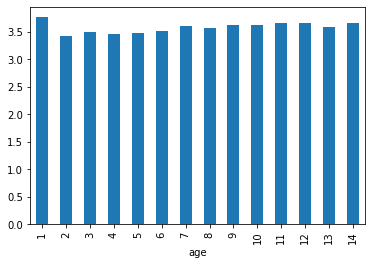

In [8]:
(
    data_df
    .groupby('age')
    ['rating']
    .mean()
    .plot(kind='bar')
)

plt.show()

#### (2) 성별 평균 평점 확인하기
성별에 따른 평점은 큰 차이가 없어보입니다. 

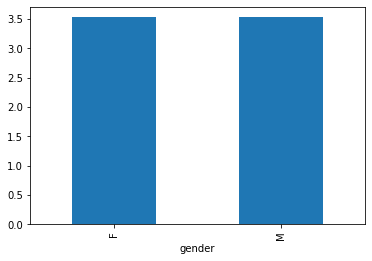

In [9]:
(
    data_df
    .groupby('gender')
    ['rating']
    .mean()
    .plot(kind='bar')
)

plt.show()

#### (3) 출시 연도별 평점 확인하기
출시 연도에 따라서 평점의 등락이 있어보입니다. 출시 연도와 평점 사이에 "최신 영화일수록 평점이 높다"는 식의 선형적인 관계는 없어보이지만, 분명 연도마다 평점의 평균 값이 차이나는 것 같습니다.

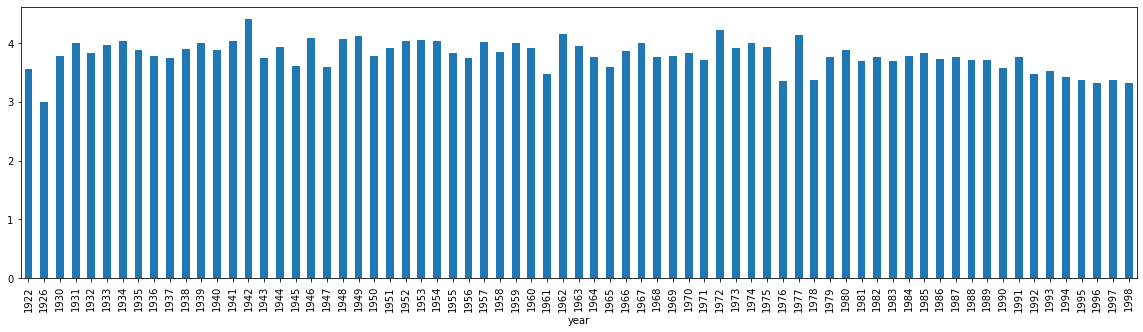

In [10]:
(
    data_df
    .groupby('year')
    ['rating']
    .mean()
    .plot(kind='bar',figsize=(20,5))
)

plt.show()

#### (4) 직업 별 평균 평점 확인하기
이번에는 직업별 평균 평점을 살펴보려 합니다. healthcare 종사자의 평균 평점이 가장 낮고, 변호사(lawyer)의 평점이 제일 높은 것으로 나왔습니다.<br>
그 이유는 알 수 없으나, 직업군에 따라 평균 평점을 주는 경향이 다른 것으로 보입니다.

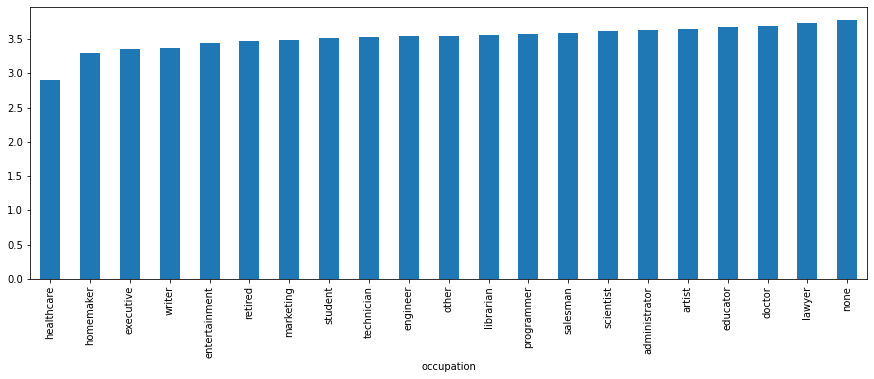

In [11]:
(
    data_df.
    groupby(['occupation'])
    ['rating']
    .mean()
    .sort_values()
    .plot(kind='bar', figsize = (15,5))
)

plt.show()

### (4) 장르 별 평균 평점 확인하기
영화 장르에 따라서는 평균 평점에 차이가 있을까요? 
코메디, 액션, 애니메이션, 드라마 장르별 영화의 평균 평점을 알아보면 다음과 같습니다.<br>
코미디는 평균 평점이 낮은 편이고, 드라마는 그에 비해 좀 더 높은 편인 것 같습니다.

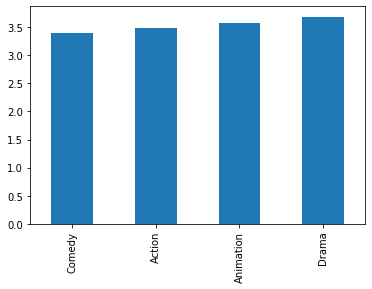

In [12]:
genres =['Comedy','Action','Animation','Drama']

genre_rating = {}
for genre in genres:
    grouped = data_df[data_df[genre]==1]
    
    avg_rating = grouped.rating.mean()
    genre_rating[genre] = avg_rating
genre_rating = pd.Series(genre_rating)

genre_rating.plot(kind='bar')
plt.show()

### 4) 특징 간의 상호 관계 파악하기

데이터의 각 특징(feature)에는 서로 상호관계가 있습니다. 예를 들어 평가를 후하게 받는 드라마 장르의 영화이더라도, 그 영화를 보는 사람이 변호사이냐 작가에 따라 선호 정도가 다를 수 있습니다. 이번에는 히트맵 분석을 통해 특징 간 상호 작용이 어떤 식으로 드러나는지를 확인해보도록 하겠습니다.

### (1) 영화 장르와 유저의 직업군에 따른 선호도 비교
4가지 장르와 6가지 직업군에 대해서 각 조합별 평균 평점을 계산하여 시각화를 해보겠습니다.

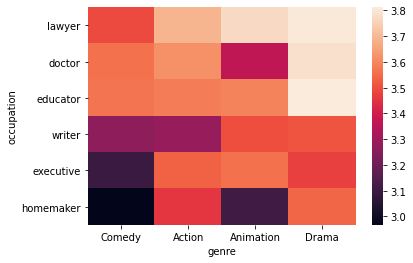

In [13]:
# 장르 정보
genres = ['Comedy','Action','Animation','Drama']
# 직업 정보
occupations = ['lawyer','doctor','educator','writer','executive','homemaker']

rows = []
for genre in genres:
    for occupation in occupations:
        grouped = data_df[(data_df[genre]==1) & (data_df['occupation']==occupation)]
        avg_rating = grouped.rating.mean()
        rows.append((genre, occupation, avg_rating))
genre_occupation_df = pd.DataFrame(rows, columns=['genre','occupation','rating'])        

pivoted = genre_occupation_df.pivot_table('rating','occupation','genre')
sns.heatmap(pivoted.loc[occupations,genres])
plt.show()

위 히트맵을 보면, 장르x직업 조합 별로 선호도가 다양하게 나타나는 것을 알 수 있습니다. 예를 들어서 의사 드라마 장르 영화에는 3.75 이상의 높은 평점을 부여한 반면, 애니메이션 분야에는 비교적 낮은 점수를 부여한 것을 확인 할 수 있습니다. 장르를 기준으로 바라보면 코메디 장르는 전반적으로 색이 진해 평점이 낮은 편이긴 하지만, 의사나 교육자 직업을 가진 유저는 비교적 높은 점수를 준 것을 확인할 수 있습니다. 

### (2) 영화 장르와 유저의 연령군에 따른 선호도 비교
이번에는 4가지 장르와 9가지 유저의 연령군에 대해서 각 조합별 평균 평점을 시각화해보겠습니다.

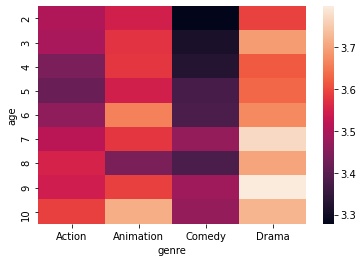

In [14]:
# 장르 정보
genres = ['Comedy','Action','Animation','Drama']
# 연령 정보
ages = [2,3,4,5,6,7,8,9,10]

rows = []
for genre in genres:
    for age in ages:
        grouped = data_df[(data_df[genre]==1) & (data_df['age']==age)]
        avg_rating = grouped.rating.mean()
        rows.append((genre, age, avg_rating))
        
genre_age_df = pd.DataFrame(rows, columns=['genre','age','rating'])        
sns.heatmap(genre_age_df.pivot_table('rating','age','genre'))
plt.show()

위 히트맵을 보면, 연령대x장르 조합 별로 선호도가 다양하게 나타나는 것을 알 수 있습니다. <br>
전반적으로 나이가 많을 수록 평점을 후하게 주고, 코미디 장르에서 평점이 낮은 것을 알 수 있는데,<br>
나이가 많아도 애션과 코미디 장르의 평점은 후하지 않다는 점이나 애니메이션의 평점은 나이에 따라 편차가 크다는 것을 알 수 있습니다. <br>
<br>
이처럼 변수 조합에 따라 평균 평점을 계산하여 시각화해보니, 앞서 한 가지 변수만을 기준으로 평균 평점을 보았을 때는 보이지 않았던 여러 상관관계가 보입니다.<br>
따라서 추천 시스템을 설계 할 때 직업과 장르, 직업과 나이 등 특징 조합간의 상호작용을 적절히 고려한다면, 보다 의미있는 추천을 할 수 있을 것입니다. 

# \[ 2. 기본 개념 \] : 범주형 데이터와 Factorization Machine(FM)
---

## 1. 정형 데이터의 종류

고객 또는 상품의 특성은 수치형 데이터(Numerical Data)과 범주형 데이터(Categorical Data)로 구분됩니다. 범주형 데이터는 관측 결과가 몇 개의 항목 혹은 범주의 형태로 나타낼 수 있는 데이터입니다. 범주형 데이터의 범주를 1, 2, 3 등 숫자로 치환하여 표현할 수도 있지만, 수치형 데이터와 달리 값의 순서와 크기가 의미를 갖지 않습니다. 대표적으로 "남/여", "직업" 등이 범주형 데이터에 속하는데, 남자를 0, 여자를 1이라고 표현한다 해도 그 숫자에는 특별한 의미가 없다는 것이죠. 한편, 수치형 데이터는 평점, 구매횟수, 유저가 사이트에 머무린 시간 등 숫자 자체가 의미를 가지는 데이터를 뜻합니다. 이러한 데이터를 우리는 "정형 데이터(Structured Data)"라고 부릅니다. 정형 데이터는 흔히 아는 "표" 형태로 열과 행에 따라 값을 채워넣을 수 있는 데이터를 뜻하며, 그 값은 범주형 데이터 혹은 수치형 데이터로 표현할 수 있습니다. 

![범주형 데이터와 수치형 데이터](https://i.imgur.com/GjxGdH7.png)

앞서 유저 정보와 영화 정보, 그리고 평점 정보를 합쳐 `data_df`을 만들었습니다. `data_df`의 각 행(로그데이터)에는 수치형 데이터(예: `rating`)뿐 아니라, 범주형 데이터(`title`,`year`,`gender`,`age`, `occupation`, 장르 등)도 있습니다. 
<br>

In [15]:
data_df.head()

,user_id,item_id,rating,title,year,unknown,Action,Adventure,Animation,Children,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation
0,196,242,3,Kolya (1996),1997,0,0,0,0,0,...,0,0,0,0,0,0,0,9,M,writer
1,196,257,2,Men in Black (1997),1997,0,1,1,0,0,...,0,0,0,1,0,0,0,9,M,writer
2,196,111,4,"Truth About Cats & Dogs, The (1996)",1996,0,0,0,0,0,...,0,0,1,0,0,0,0,9,M,writer
3,196,25,4,"Birdcage, The (1996)",1996,0,0,0,0,0,...,0,0,0,0,0,0,0,9,M,writer
4,196,382,4,"Adventures of Priscilla, Queen of the Desert, ...",1994,0,0,0,0,0,...,0,0,0,0,0,0,0,9,M,writer


## 2. 범주형 데이터를 숫자로 표현하는 방법

### (1) 원핫인코딩
`data_df`를 보면, 장르 정보가 "genre"라는 칼럼을 따로 두고 값을 "Action"이나 "Adventure"라고 채워넣은 것이 아니라,장르명을 칼럼으로 두고, 유저가 평가한 영화가 해당 장르에 속하면 1로 마킹한 것을 볼 수 있습니다. 범주형 데이터를 이렇게 표현하는 방식을 "원핫 인코딩(OHE; One-hot Encoding)"이라고 부릅니다. 
<br>
이처럼 범주형 데이터를 이용해 머신러닝 모델을 만들기 위해서는 범주형 데이터를 숫자로 바꾸어주는 인코딩(Encoding) 작업을 먼저 해야합니다. 즉, 숫자 크기에 의미는 없지만, 컴퓨터에서 특성을 인식할 수 있도록 숫자로 표현해주는 것을 뜻합니다. 앞서 언급한 원핫 인코딩은 가장 기본적인 형태의 인코딩입니다. <br>
<br>
개념을 이해하였으니 직접 인코딩을 해봅시다. 직업(`occupation`)을 원핫인코딩을 거쳐 표현하고 싶은 직업 칼럼에 1의 값을 부여하고, 다른 직업 칼럼에는 0을 부여해보겠습니다. <br>

In [16]:
sample_df = data_df.sample(5,random_state=0)
sample_df.occupation

59041         other
50627      educator
82548         other
65372    programmer
15823       student
Name: occupation, dtype: object

위의 구조를 아래와 같이 변경하는 것이 바로 원핫-인코딩입니다. pandas의 `get_dummies()`를 이용합니다.

In [17]:
pd.get_dummies(sample_df.occupation)

,educator,other,programmer,student
59041,0,1,0,0
50627,1,0,0,0
82548,0,1,0,0
65372,0,0,1,0
15823,0,0,0,1


위와 같이 표현했을 때 이점은 무엇이 있을까요? 바로 범주형 별로 각각 **가중치**를 줄 수 있다는 점입니다. <br> 

예를 들어 직업이라는 데이터를 이용해 수식을 쓴다면 아래와 같이 작성을 할 수 있게 됩니다.
$$
y = w_0 + w_{educator} x_{educator} + w_{other} x_{other} + w_{programmer} x_{programmer} + w_{student} x_{student}
$$

위의 케이스들을 수식에 대입시키게 되면

$$
y_0 = w_0 + w_{educator}*0 + w_{other} * 1 + w_{programmer} * 0 + w_{student} * 0 \\
y_1 = w_0 + w_{educator}*1 + w_{other} * 0 + w_{programmer} * 0 + w_{student} * 0 \\
y_2 = w_0 + w_{educator}*0 + w_{other} * 1 + w_{programmer} * 0 + w_{student} * 0 \\
y_3 = w_0 + w_{educator}*0 + w_{other} * 0 + w_{programmer} * 1 + w_{student} * 0 \\
y_4 = w_0 + w_{educator}*0 + w_{other} * 0 + w_{programmer} * 0 + w_{student} * 1 \\
$$


와 같이 수식이 전개가 됩니다.

각 직업에 따라 예측 결과의 오차를 최소화 할 수 있는 가중치를 따로 따로 찾아가는 것입니다. 

### (2) 카테고리 인덱싱을 통한 범주형 데이터의 인코딩

하지만 위와 같이 원핫인코딩을 하여 만든 0과 1로 구성된 행렬을 그대로 사용하게 되면, 불필요하게 메모리를 많이 소모하게 된다는 단점이 있습니다. <br>
즉, 어떤 유저가 "프로그래머"라는 정보만 가지고 있어도 되는데, "교육자 아님, 학생 아님, 기타 직업 아님"라는 불필요한 정보까지 계속 가지고 가게 되는 것이죠. <br>
어떻게 하면 같은 정보를 담으면서도 데이터 크기를 최소화하여 처리 속도를 높일 수 있을까요? 
<br>

다양한 인코딩 방법이 있겠지만, 그 중에서도 각 범주에 대해 코드값을 지정하고 그 코드값으로 인덱싱하는 방식의 인코딩을 진행해 보겠습니다.<br>
이 방법은 아직 일반적으로 통용되는 용어가 없기에 이 시간에는 `카테고리 인덱싱`이라 하겠습니다. <br>
결과는 원핫인코딩과 같지만, 범주를 하나씩 열(column)로 추가하지 않아 데이터의 크기를 최소화하여 처리 속도를 높일 수 있는 방법입니다.<br>
원핫인코딩과 카테고리 인덱싱은 다음과 같이 비교할 수 있습니다.

![fm_6](https://i.imgur.com/D8YmgUO.png)

Movie-Lens 데이터에서 범주형 데이터로 활용할 특성들을 지정하여 인덱싱을 하고자 합니다. <br>
pandas에서는 이와 같은 범주형 데이터를 손쉽게 다룰 수 있도록 "Category"라는 데이터타입을 제공합니다.<br>
이를 활용하여 범주형 값을 인덱스 값으로 대체해 보겠습니다.

In [18]:
# 범주형 데이터로 활용할 컬럼들만 따로 이름을 저장합니다.
genre_names = movies_df.columns[3:]
cate_cols = ["user_id", "item_id", "year", "age", "gender", "occupation"] + list(genre_names)
print(cate_cols)

['user_id', 'item_id', 'year', 'age', 'gender', 'occupation', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [19]:
# 범주형 데이터는 아래와 같이 저장되어 있습니다.
data_df.loc[:, cate_cols].sample(5, random_state=1)

,user_id,item_id,year,age,gender,occupation,unknown,Action,Adventure,Animation,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
27819,327,962,1993,4,M,student,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86043,89,83,1993,8,F,administrator,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
14316,500,709,1992,5,M,administrator,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
91233,923,763,1996,4,M,student,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28761,704,344,1997,10,F,librarian,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


pandas에서는 범주형 데이터를 활용하기 좋도록 "category"라는 dtype을 지원합니다.

In [20]:
for col in cate_cols :
    data_df.loc[:, col] = data_df.loc[:, col].astype('category')

In [21]:
# 카테고리컬 특성의 값을 index로 대체합니다.
def cate2int(df):
    cate_sizes = {}
    for col_name in df.columns:
        if pd.api.types.is_categorical_dtype(df[col_name]):
            cate_sizes[col_name] = len(df[col_name].cat.categories)
            df.loc[:,col_name] = df[col_name].cat.codes
    
    return df, cate_sizes

data_df, cate_sizes = cate2int(data_df)

In [22]:
# 범주형 데이터가 다음과 같이 index로 변경되었습니다.
data_df.loc[:, cate_cols].sample(5, random_state=1)

,user_id,item_id,year,age,gender,occupation,unknown,Action,Adventure,Animation,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
27819,326,960,65,3,1,18,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86043,88,82,65,7,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
14316,499,707,64,4,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
91233,922,761,68,3,1,18,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28761,703,342,69,9,0,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# 변경된 범주형 특성이 무엇인지, 크기가 얼마인지 따로 지정하여 저장하였습니다.
print(cate_sizes)

{'user_id': 943, 'item_id': 1681, 'year': 71, 'unknown': 2, 'Action': 2, 'Adventure': 2, 'Animation': 2, 'Children': 2, 'Comedy': 2, 'Crime': 2, 'Documentary': 2, 'Drama': 2, 'Fantasy': 2, 'Film-Noir': 2, 'Horror': 2, 'Musical': 2, 'Mystery': 2, 'Romance': 2, 'Sci-Fi': 2, 'Thriller': 2, 'War': 2, 'Western': 2, 'age': 14, 'gender': 2, 'occupation': 21}


이렇게 지정된 인덱스를 Factorization Machine에서 가중치를 호출할 때 인덱스로 활용할 수 있습니다.<br>
이 부분은 다음 섹션에서 다룰 "케라스의 임베딩 레이어"를 이해하는 데 중요하므로 잘 알아두어야 합니다. <br>
이제, 활용할 데이터의 준비가 모두 끝났습니다. 다음 절에서는 이번 주차에 추천시스템을 만드는 데 활용될 모델인 Factorization Machine의 기본개념을 배워보겠습니다.

## 3. 특성 간의 상호관계 - FM모델의 필요성

지난 시간에 다뤘던 협업 필터링 모델에서는 `user_id`, `item_id`, `timestamp` 등으로 구성된 상호작용 데이터(고객 행동데이터)를 활용하여 유저-아이템 행렬(User-Item Matrix)를 구성한 후 문제를 해결하였습니다.<br>
하지만 현업 실무에서는 다양한 특성 데이터를 활용할 수 있습니다.<br>
예컨데, Item의 장르 또는 카테고리나, User의 인구통계학적 정보, 태그 정보 등등 다양한 정보들이 있겠지요.<br>
이러한 유저와 아이템의 특성 데이터는 어떻게 표현하는지 알아보고, 특성 데이터의 특징을 살려 추천하는 추천 알고리즘 "Factorization Machine"에 대해 알아봅시다.

### (1) 특성 테이블(Feature Table)
이전 시간에 배운 협업필터링에서 활용하는 유저-아이템 행렬(User-Item Matrix)은 유저와 아이템을 각각 행과 열로 표현했었습니다.<br>
그리고 예측 타겟(target)이 되는 평점(rating)을 값(value)으로 갖는다는 특징이 있었죠.<br>
위와 같은 특성데이터를 유저-아이템 행렬에 함께 담기는 어렵습니다. <br>
따라서 아래와 같이 각 로그의 여러가지 특성을 열로 표현한 특성 테이블(Feature table)을 구성해야 합니다.<br>

![feature_table](https://i.imgur.com/fTwPYWa.png)

이렇게 구성된 특성 테이블은 유저-아이템 행렬에 비해 다음과 같은 장점을 가집니다.<br>

1. 고객과 아이템 식별자 이외에도 다양한 특성들을 함께 적용할 수 있습니다.
2. 유저-아이템 행렬이 희소성(Sparsity)으로 인해 비대해지는 문제를 피할 수 있습니다.
3. 새로운 로그가 추가되었을때 테이블 하단에 행에 추가하기만 하면 되므로, 확장성을 가집니다.


### (2) 특성 간 상호관계

특성 테이블의 각 특성(feature)가 예측 타겟(target, 여기서는 평점)에 미치는 영향을 잘 반영하는 추천 시스템을 만들어야 합니다.<br>
하지만 특성의 관계는 복잡하게 구성되어있기 때문에 각각의 특성을 독립적으로 고려하여 타겟을 예측하기에는 조금 부족합니다.<br>
예컨데 앞서 살펴본대로 나이대와 영화 장르별로 조합을 만들고 평균 평점을 계산해보였을 때, 조합마다 서로 다른 양상을 보였었습니다.
즉, 나이라는 특성과 성별이라는 특성의 상호 작용을 고려하여, 나이가 20대 후반일때의 학생과 50대 초반일때의 학생의 예상 평점을 예측하는 해보면 다를 수 있다는 것이죠. 

![](https://i.imgur.com/TlSNuEY.png)

FM모델은 이러한 특성 간의 교호작용(Interaction)이 예측 타겟에 미치는 영향까지 고려하는 모델입니다.<br>
그럼, 이제 Factorization Machine(FM)의 기본 아이디어를 알아보겠습니다.


## 4. Factorization Machine(FM)의 아이디어

Factorization Machine은 각 특성의 영향을 고려하는 다중선형회귀에 특성 간의 상호관계를 고려하는 부분이 추가된  모델입니다.<br>
그 수식은 아래와 같이 다중선형회귀부분과 특성 간의 상호작용 부분의 합으로 구성되어있습니다.

![w5_1_math](https://i.imgur.com/Qt4vs3B.png)

각각의 부분에 대해 이해해봅시다.

### (1) 다중선형회귀(Multiple Linear Regression) 부분

이전 시간에 선형회귀(Linear Regression)이라는 머신러닝 모델을 배웠습니다.<br>
선형회귀모델은 독립변수를 통해 종속변수의 값을 예측하는데요,<br>
Movie-lens데이터와 같이 독립변수가 여러개 있을 경우 다중선형회귀(Multiple Linear Regression)이라고 합니다.

예시를 하나 들어보겠습니다. 아래에 user_id가 195번인 고객의 item_id가 172인 영화에 대한 로그데이터가 있습니다.<br>
195번 유저가 172번 영화 Princess Bride, The (1987)에 대해 남긴 평점은 2점입니다.<br>
이 로그데이터에서는 위에서 처리한 바와 같이 195번 고객의 특성과 172번 영화의 특성이 함께 담겨있습니다.

In [24]:
row = data_df.loc[
    (data_df.user_id==195) 
    & (data_df.item_id==172), :]
row

,user_id,item_id,rating,title,year,unknown,Action,Adventure,Animation,Children,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation
10,195,172,2,"Princess Bride, The (1987)",59,0,1,1,0,0,...,0,0,1,0,0,0,0,8,1,20


195번 고객은 172번 영화()에 대해 2점이라는 평점을 부여했는데요,<br>
고객의 취향과 함께, 고객의 나이, 성별, 직업뿐 아니라 영화의 제작년도, 장르와 같은 특성이 함께 복합적으로 작용하여 드러난 평가일 것입니다.<br>
그 "복합적인 작용"을 파악한다면 우리는 특성 벡터(feature vector)가 주어졌을 때 평점을 예측해 볼 수 있을 것입니다.<br>
예컨데 그 "복합적인 작용"을 함축하고 있는 가중치로 다음과 같이 평점이 결정될 수 있습니다.

$$w_0 + w_{user\_195} + w_{user\_172} + w_{year\_59} + w_{unknown\_0} + w_{action\_1} + w_{adventure\_0} ... + w_{age\_8} + w_{gender\_1} + w_{occupation\_20} = 2$$

여기서, $w_0$는 이전시간의 선형회귀에서 배웠듯 전체 편향을,<br>
$w_{user\_195}$이라 하면 195번 고객에 대한 가중치를, <br>
$w_{action\_1}$이라하면 해당 영화가 action 장르를 가질 때의 가중치를, <br>
$w_{age\_8}$라 하면 고객의 나이 범주가 8일 때의 가중치를 의미합니다.<br>
이와 같이 다양한 특성들의 가중치로 평점이 결정될 수 있다는 것이지요.

이렇듯, 특성에 의해 평점의 예측값을 찾는 것은 이전 시간에 선형회귀(Linear Regression)와 손실함수를 학습하며 배웠습니다.<br>
선형회귀는 예측 값과 실제값의 오차를 최소화하는 가중치를 찾게됩니다. 
다중선형회귀(Multiple Linear Regression)는 그 특성의 수가 여러개 있는 경우입니다.

예를 하나 들어보겠습니다.<br>
만약 user_id가 195일 경우, item_id가 172인 아이템에 대한 평점을 예측한다고 해보겠습니다.<br>
그러면 아래와 같이 특성 데이터(feature)와 실제 결과값(target)을 획득할 수 있습니다.

In [25]:
X = row[["user_id", "item_id", "year", "Drama", "occupation"]]
y = row[["rating"]]

display(X)
display(y)

,user_id,item_id,year,Drama,occupation
10,195,172,59,0,20


,rating
10,2


여기서, 우리는 다음과 같은 가중치가 있다고 가정해 봅시다.

In [26]:
global_bias   = 1.4
user_weights  = { 194:  0.3, 195:  0.1, 196:  0.2 }
item_weights  = { 171: -0.1, 172:  0.3, 173:  0.2 }
year_weights  = {  58:  0.7,  59: -0.6,  60: -0.1 }
drama_weights = {  0:  0.3,    1: -0.6 }
occu_weights  = {  19:  0.1,  20:  0.5,  21: -0.3 }

그렇다면 우리는 레이팅을 다음과 같이 예측해 볼 수 있습니다.

In [27]:
(
    global_bias 
    + user_weights[195] 
    + item_weights[172] 
    + year_weights[59] 
    + drama_weights[0] 
    + occu_weights[20]
)

2.0

이런식으로 각 유저의 특성 데이터에서 평점을 예측할 수 있는 가중치 값을 찾고자 하는것이 다중선형회귀(Multiple Linear Regression)의 목표입니다.

### (2) 특성 간 상호작용 부분

다중선형회귀는 각 특성의 개별적인 가중치를 찾아내지만, 특성들이 상호간에 갖는 관계를 고려하지는 못합니다.<br>
FM 모델은 데이터의 특성 뿐 아니라 각 특성간의 상호 관계를 함께 고려하기 위해 모든 특성별 관계에 대해 최적의 가중치를 찾습니다.<br>
FM에서는 특성 $i$와 특성$j$ 간의 상호관계($x_ix_j$)에 대한 가중치는 다음과 같이 가중치 벡터곱($\langle \mathbf{v}_i,\mathbf{v}_j \rangle $)으로 나타냅니다.<br>
아래는 논문([Factorization Machine, Rendle](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf))에 이를 표현된 수식입니다.<br>
$$\langle \mathbf{v}_i,\mathbf{v}_j \rangle x_ix_j$$

FM 모델에는 바로 이 특성간 상호작용에 대한 가중치의 최적값을 찾아가는 부분이 다중선형회귀 모델에 추가된 것입니다.<br>
위 수식은 개별 로그의 값에 적용되는 수식이었습니다.<br>
즉, 로그를 남긴 유저의 "나이"가 3번 클래스에 속하고, "직업"이 1번 클래스에 속한다면,<br>
그 로그의 두 특성의 상호작용($x_{age}x_{occupation}$)에 대한 가중치는 $\langle \mathbf{v}_{age,3},\mathbf{v}_{occupation,1} \rangle $로 표현될 것입니다.<br>

그렇다면 전체 데이터에서 각 특성간의 상호작용에 대한 가중치는 벡터가 아닌 행렬로 표현될 것입니다.
이를 "특성$i$의 다른 특성과의 상호작용 임베딩 행렬" $E_i$라고 부릅니다.<br>
그렇다면 특성간의 상호관계 임베딩의 벡터곱을 다음과 같이 수정할 수 있습니다.<br>

$$\langle \mathbf{E}_{i,i\_class\_index},\mathbf{E}_{j, j\_class\_index} \rangle$$

FM모델은 특성간의 상호작용에 대한 최적의 가중치를 구할 수 있는 임베딩 행렬 ${E}_{i}, {E}_{j}$ 를 찾아내는 것이죠.<br>
특성 $i$의 다른 특성과의 상호작용 임베딩 행렬 $E_i$의 형태(shape)는 (특성 $i$의 클래스 수, FM모델의 사이즈 $k$)와 같습니다.<br>
FM모델 사이즈 $k$는 직접 지정할 수 있습니다. $k$를 매우 큰 값으로 잡으면 FM모델은 가능한 모든 상호작용 관계에 대한 가중치를 표현하는 임베딩 행렬을 만들 것입니다.<br>
하지만 복잡한 상호작용 관계를 추정하기에 데이터가 충분히 많지 않다면 $k$를 작은 수준으로 제한해줘야 보다 일반화가 가능한 안정적인 FM모델을 만들 수 있습니다. <br>

![Embedding](https://i.imgur.com/ZBXgjM6.png)

임베딩 행렬이 위와 같고, 어떤 한 로그데이터에서 유저의 나이가 15세~19세 사이이며 영화의 개봉 연도가 1930년일 경우 <br>
그 로그에서 유저의 나이와 영화의 개봉년도간의 상호작용이 rating에 미치는 영향은 다음과 같이 계산할 수 있습니다.

![](https://i.imgur.com/c0lEzg1.png)

이렇게, 한 특성의 다른 특성과의 상호관계를 임베딩한 벡터로 부터 얻은 가중치를 이용하여, 두 변수의 상호작용 관계를 예측에 더해줍니다.

# \[ 3. 알고리즘 \]
---

## 1. 커스텀 레이어로 FM의 각 부분 구성하기
Factorization Machine은 케라스에서 따로 지원해주는 기능이 없어 직접 구현해야 하는데 이때 사용할 수 있는 것이 커스텀 레이어입니다. <br>
커스텀 레이어의 개념을 알아보고, 커스텀 레이어를 이용해 FM을 구성하는 (1) 선형 회귀 파트와 (2) 특성간 상호 관계 파트를 각각 커스텀 레이어로 구성한 후에 이를 합쳐서 (3) 최종 FM모델을 구성해보겠습니다. 

### (1) 케라스 커스텀 레이어(Custom Layer)의 개념
케라스는 기본적으로 딥러닝을 위해 만들어진 프레임워크였기 때문에 층(layer)를 조합하여 모델을 설계합니다. <br>
층은 학습해야 할 가중치와 학습 방법을 정의하여 입력하면, 입력한 텐서에 대해 결과를 출력하는 역할을 합니다.<br>
앞서 DNN 시간에 배운 Keras의 `Dense`와 `Input` 모두 `Layer`였으며, 이 외에도 직접 `Layer`을 정의하여 사용할 수 있습니다.<br>
이렇게 사용자가 직접 정의하여 사용하는 레이어를 "커스텀 레이어"라고 부릅니다. <br>
`keras.layers`의 `Layer`를 불러와 다음과 같이 `MyLayer`라는 커스텀 레이어의 인자로 넣어주면, `Dense`와 `Input`와 같은 방법으로 사용할 수 있습니다.

```python
from keras import backend as K
from keras.layers import Layer

class MyLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        # 해당 Layer에서 Block등을 활용해 구조를 생성할 수 있습니다.        
        self.output_dim = output_dim
        super().__init__(**kwargs)

    def build(self, input_shape):
        # 이 레이어에서 학습시킬 가중치를 정의해주세요.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1], self.output_dim))
        super().build(input_shape)

    def call(self, x):
        # Layer의 input(x)에 의해 산출되는 결과를 정의합니다.
        return K.dot(x, self.kernel)  
```

### (2) Linear Regression Part

이전 시간을 통해 Linear Regression에 대해서 배웠습니다. 선형회귀를 식으로 간략하게 표현하면 아래와 같습니다.<br>
$$ logits_{lr} = w_0 + \sum^n_{i=1}w_ix_i$$

이를 케라스 커스텀 레이어로 만들면 다음과 같습니다.


In [28]:
from tensorflow.keras.layers import Layer

class LinearModel(Layer):
    """
    Linear Logit
    y = w0 + x1 + x2 + ...
    """
    def build(self, input_shape):
        self.b = self.add_weight(shape=(1,),
                                 initializer='zeros',
                                 trainable=True)
        super().build(input_shape)    
    
    def call(self, inputs, **kwargs):
        logits = tf.add_n(inputs) + self.b
        return logits

### (3) Factorization Machine Part

다음은 특성간의 상호관계를 고려하는 $logit_{fm}$ 부분입니다.<br>
FactorizationMachine의 핵심이 되는 부분이므로, 이 부분의 레이어 이름을 `FactorizationMachine`으로 하겠습니다.
$$logits_{fm} =  \sum^n_{i=1}\sum^n_{j=i+1}\langle \mathbf{v}_i,\mathbf{v}_j \rangle x_ix_j$$


In [29]:
from itertools import combinations

class FactorizationMachine(Layer):
    """
    Factorization Machine Layer
    """
    def call(self, inputs, **kwargs):
        logits = 0.
        for v_i, v_j in combinations(inputs, 2):
            logits += tf.reduce_sum(v_i * v_j, axis=-1)
        return logits

#### \[ Additional \] 

하지만 위의 식은 특성의 수($n$)가 증가할 때마다 연산량을 $kn^2$로 증가시키게 되는데요,<br>
이러한 특성 상호관계 부분은 다음과 같이 식을 수정하여 특성의 수($n$)가 증가할 때 $kn$ 연산량이 증가하도록 할 수 있습니다.
$$ logits_{fm} = \frac{1}{2} \sum^k_{f=1}\Bigg(\bigg(\sum^n_{i=1}v_{i,f}x_i\bigg)^2 - \sum^n_{i=1}v^2_{i,f}x^2_i\Bigg) $$

두 수식은 동일한 수식이며, 이에 대한 증명은 아래와 같습니다.

<img src="https://i.imgur.com/MtRMqsy.png" width="300">

In [30]:
class FactorizationMachine(Layer):
    """
    Factorization Machine Layer
    """
    def call(self, inputs, **kwargs):
        # List of (# Batch, # Embed) -> (# Batch, # Features ,# Embed)
        inputs = tf.stack(inputs, axis=1) 

        logits = tf.reduce_sum(
            tf.square(tf.reduce_sum(inputs, axis=1))
            - tf.reduce_sum(tf.square(inputs), axis=1)
            , axis=1, keepdims=True) / 2.
        return logits

## 3. 임베딩 레이어와 커스텀 레이어로 Factorization Machine(FM) 구현하기

지금까지 배운 FM 모델의 전체적인 구성을 그림으로 표현하면 아래와 같습니다.<br>
![](https://i.imgur.com/b770s7P.png)
전체적으로 LinearModel 부분과, FactorizationMachine 부분이 병렬적으로 작동한 후 결과값을 더하여 예측합니다.<br>
각 부분에서 사용할 데이터는 먼저 임베딩 레이어로 만들어주어야 합니다. 

In [31]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model

In [32]:
fm_size = 8
col_names = ["user_id", "item_id", "age", "year"]

inputs = []
fm_embeds = []
linear_embeds = []

# Embedding Part : 모든 칼럼에 대해 임베딩을 해줍니다. 
for col_name in col_names:
    x = Input(shape=(), name=col_name)
    input_embed_dim = cate_sizes[col_name]        
    lr_out = Embedding(input_embed_dim, 1,
                       name=f'{col_name}_lr_embed')(x)

    fm_out = Embedding(input_embed_dim, fm_size,         
                       name=f'{col_name}_fm_embed')(x)
    inputs.append(x)
    linear_embeds.append(lr_out)
    fm_embeds.append(fm_out)

이제 임베딩 레이어 `linear_embeds`와 `fm_embeds`를 만들었으니, 각각을 `LinearModel`과 `FactorizationMachine` 부분에 입력값으로 넣어주어야 합니다. 

In [33]:
# LR Model Part
lr_logits = LinearModel(name='lr')(linear_embeds)

# FM model part
fm_logits = FactorizationMachine(name='fm')(fm_embeds)

# LR 파트와 FM파트를 합쳐서 최종 모델을 만들어줍니다. 
pred = lr_logits + fm_logits
model = Model(inputs, pred, name='movielens')

이 부분에 대한 자세한 내용은 아래 샘플코드를 보며 설명하겠습니다. 

# \[ 4. 샘플 코드 \]
---

## 1. Movie-Lens 데이터를 이용해 FM 모델 만들기

이제, 실제 데이터를 이용해 FM 모델을 사용해보겠습니다. Movie-lens에서는 위에서 다룬 것과 같이 다양한 범주형 특성과 수치형 특성이 제공됩니다.<br>
이번에는 고객의 특성 중 범주형 특성인 "나이(age)"특성과 영화의 특성 중 "개봉년도(year)"특성을 추가로 활용하여 `(user_id, item_id, age, year, rating)` 칼럼으로 구성된 형태의 데이터로 진행해보겠습니다.

|user_id|item_id|age|year||rating|
|---|---|---|---|---|---|
|..|...|...|...||...|

In [34]:
data_df.loc[:, ["user_id", "item_id", "age", "year", "rating"]].sample(5)

,user_id,item_id,age,year,rating
49639,626,433,3,41,5
56992,187,1211,7,65,2
28216,639,1008,3,68,3
9413,89,659,11,24,5
38340,882,987,8,69,5


### 1) 데이터 세팅
먼저 사용될 특성을 선택하고, 입력 데이터(`X`)와 예측 목표 데이터(`y`)를 분리하고, 모델 훈련에 사용할 데이터와 테스트에 사용할 데이터를 분리하겠습니다.<br>

**활용될 특성 선택 및 Input 과 Target분리**<br>
가장 먼저, 입력값으로 활용할 특성을 전체 데이터에서 꺼내와 `X`에 담고, 예측 타겟(`y`)을 분리하겠습니다.

In [35]:
X = data_df.loc[:, ["user_id", "item_id", "age", "year"]] 
y = data_df[['rating']]

**trainset과 testset으로 구분하기**<br>
그 다음으론 훈련 데이터 90% : 테스트 데이터 10%로 분리하겠습니다.

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1,
                                                    random_state=12345)

**텐서로 바꾸어 주기**<br>
이제 데이터를 케라스에서 용이하게 활용할 수 있도록 텐서 형태로 변경하겠습니다. 

In [37]:
trainset = tf.data.Dataset.from_tensor_slices(
    ({k : v.values.astype(np.int32) 
      for k, v in X_train.iteritems()}, 
     y_train.values))

validset = tf.data.Dataset.from_tensor_slices(
    ({k : v.values.astype(np.int32) 
      for k, v in X_test.iteritems()}, 
     y_test.values))

### 2) 학습될 모델 세팅

옵티마이저로는 `Adagrad`를 사용하고 학습률은 0.1 설정합니다. 예측 모델이므로 모델을 평가하는 기준으로 케라스의 `RootMeanSquaredError`를 사용하겠습니다.

In [38]:
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

model.compile(optimizer=Adagrad(learning_rate=0.1),
              loss=MeanSquaredError(), 
              metrics=[RootMeanSquaredError()])

### 3) 모델에 학습
전체 데이터에 대해 모델은 총 50회 학습한다면 `num_epoch`를 50으로 설정합니다.<br>
한편, 한 epoch 안에서 전체 데이터를 한 번에 학습시키지 않고 데이터를 쪼개서 학습시킨다면, 쪼개는 단위인 배치 사이즈(`batch_size`)를 설정합니다.<br>
이번에는 배치 사이즈를 256으로 설정하겠습니다.

In [39]:
batch_size = 256 
num_epoch = 50

hist = model.fit_generator(
    (trainset
     .shuffle(batch_size*10)
     .batch(batch_size)),
    epochs=num_epoch,
    validation_data=validset.batch(batch_size*4))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
352/352 [==============================] - 1s 2ms/step - loss: 1.5568 - root_mean_squared_error: 1.2477 - val_loss: 0.9709 - val_root_mean_squared_error: 0.9854
Epoch 2/50
352/352 [==============================] - 1s 2ms/step - loss: 0.9165 - root_mean_squared_error: 0.9574 - val_loss: 0.9295 - val_root_mean_squared_error: 0.9641
Epoch 3/50
352/352 [==============================] - 1s 2ms/step - loss: 0.8838 - root_mean_squared_error: 0.9401 - val_loss: 0.9179 - val_root_mean_squared_error: 0.9580
Epoch 4/50
352/352 [==============================] - 1s 2ms/step - loss: 0.8692 - root_mean_squared_error: 0.9323 - val_loss: 0.9114 - val_root_mean_squared_error: 0.9547
Epoch 5/50
352/352 [==============================] - 1s 2ms/step - loss: 0.8605 - root_mean_squared_error: 0.9277 - val_loss: 0.9076 - val_root_mean_squared_error: 0.9527
Epoch 6/50
352/352 [==============================] - 1s 2ms/ste

<hr>
<div style = "background-image: url('https://pai-picture.s3.ap-northeast-2.amazonaws.com/PAI-Identity/PublicAI+Logo.png');background-repeat: no-repeat; background-position: right; background-size: 60px 40px; padding : 5px 70px 5px 5px;">
    Copyright(c) 2020 by Public AI. All rights reserved.<br>
    Writen by PAI, SeonYoul Choi ( best10@publicai.co.kr )  last updated on 2020/06/22
</div>
<hr>